In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error




# Load Data (without any date parsing initially)
weather_data = pd.read_excel('weather_data_last.xlsx')
spotify_data = pd.read_excel('Spotify_Data.xlsx')
netflix_data = pd.read_excel('NetflixViewingHistory.xlsx')

# Convert all dates to datetime explicitly
weather_data['date'] = pd.to_datetime(weather_data['date'])
spotify_data['Date'] = pd.to_datetime(spotify_data['Date'])
netflix_data['Date'] = pd.to_datetime(netflix_data['Date'])

# Standardize column names
weather_data = weather_data.rename(columns={'temperature_2m_mean': 'MeanTemperature'})
spotify_data = spotify_data.rename(columns={
    'Date': 'date',
    'Total Minutes': 'SpotifyMinutes'
})
netflix_data = netflix_data.rename(columns={
    'Date': 'date',
    'Duration': 'NetflixDuration'
})

# Aggregate Netflix data by date (in case of multiple entries per day)
netflix_daily = netflix_data.groupby('date')['NetflixDuration'].sum().reset_index()

# Merge datasets
# First merge weather and netflix
merged_data = pd.merge(
    weather_data,
    netflix_daily,
    on='date',
    how='left'
)

# Then merge with spotify
merged_data = pd.merge(
    merged_data,
    spotify_data,
    on='date',
    how='left'
)

# Fill missing values with 0
merged_data['NetflixDuration'] = merged_data['NetflixDuration'].fillna(0)
merged_data['SpotifyMinutes'] = merged_data['SpotifyMinutes'].fillna(0)

# Print verification information
print("\nVerification:")
print(f"Original data sizes:")
print(f"Weather data: {len(weather_data)} rows")
print(f"Spotify data: {len(spotify_data)} rows")
print(f"Netflix data: {len(netflix_data)} rows")
print(f"Netflix daily aggregated: {len(netflix_daily)} rows")

print(f"\nMerged data: {len(merged_data)} rows")
print(f"Days with Netflix viewing: {(merged_data['NetflixDuration'] > 0).sum()}")
print(f"Days with Spotify listening: {(merged_data['SpotifyMinutes'] > 0).sum()}")

# Show a sample of the merged data
print("\nSample of merged data:")
print(merged_data.head())

# Additional verification
print("\nDate ranges in merged data:")
print(f"Start date: {merged_data['date'].min()}")
print(f"End date: {merged_data['date'].max()}")

# Check for any missing dates
print("\nMissing values in final dataset:")
print(merged_data.isnull().sum())


Verification:
Original data sizes:
Weather data: 368 rows
Spotify data: 331 rows
Netflix data: 114 rows
Netflix daily aggregated: 114 rows

Merged data: 368 rows
Days with Netflix viewing: 52
Days with Spotify listening: 331

Sample of merged data:
        date  MeanTemperature  NetflixDuration  SpotifyMinutes
0 2023-11-26              9.5              0.0            2.75
1 2023-11-27              4.8              0.0          335.37
2 2023-11-28              9.1              0.0          280.15
3 2023-11-29             14.4              0.0          102.74
4 2023-11-30             10.6              0.0          175.83

Date ranges in merged data:
Start date: 2023-11-26 00:00:00
End date: 2024-11-27 00:00:00

Missing values in final dataset:
date               0
MeanTemperature    0
NetflixDuration    0
SpotifyMinutes     0
dtype: int64


In [39]:
# Model 1: Classification - Platform Preference
merged_data['Platform'] = merged_data.apply(
    lambda row: 'Netflix' if row['NetflixDuration'] > row['SpotifyMinutes'] else 'Spotify', axis=1
)

# Model 2: Regression - Time Spent on Netflix or Spotify
merged_data['NetflixHours'] = merged_data['NetflixDuration'] / 60  # Convert minutes to hours
merged_data['SpotifyHours'] = merged_data['SpotifyMinutes'] / 60  # Convert minutes to hours



In [40]:


# Features and targets for Model 1 (Classification)
X_classification = merged_data[['MeanTemperature']]
y_classification = merged_data['Platform']

# Features and targets for Model 2 (Regression)
X_regression = merged_data[['MeanTemperature']]
y_netflix = merged_data['NetflixHours']
y_spotify = merged_data['SpotifyHours']

# Train-Test Split for Classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

# Train-Test Split for Regression
X_train_reg, X_test_reg, y_train_netflix, y_test_netflix = train_test_split(
    X_regression, y_netflix, test_size=0.2, random_state=42
)
_, _, y_train_spotify, y_test_spotify = train_test_split(
    X_regression, y_spotify, test_size=0.2, random_state=42
)

In [41]:


# Model 1: Random Forest Classifier for Platform Prediction
clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(X_train_cls, y_train_cls)

# Model 2: Random Forest Regressor for Netflix and Spotify Duration
reg_netflix = RandomForestRegressor(random_state=42, n_estimators=100)
reg_spotify = RandomForestRegressor(random_state=42, n_estimators=100)
reg_netflix.fit(X_train_reg, y_train_netflix)
reg_spotify.fit(X_train_reg, y_train_spotify)

RandomForestRegressor(random_state=42)

In [42]:

y_pred_cls = clf.predict(X_test_cls)
print("Classification Model - Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Classification Report:\n", classification_report(y_test_cls, y_pred_cls))

y_pred_netflix = reg_netflix.predict(X_test_reg)
y_pred_spotify = reg_spotify.predict(X_test_reg)

mse_netflix = mean_squared_error(y_test_netflix, y_pred_netflix)
mse_spotify = mean_squared_error(y_test_spotify, y_pred_spotify)

print("Regression Model - Netflix MSE:", mse_netflix)
print("Regression Model - Spotify MSE:", mse_spotify)

Classification Model - Accuracy: 0.8513513513513513
Classification Report:
               precision    recall  f1-score   support

     Netflix       0.29      0.25      0.27         8
     Spotify       0.91      0.92      0.92        66

    accuracy                           0.85        74
   macro avg       0.60      0.59      0.59        74
weighted avg       0.84      0.85      0.85        74

Regression Model - Netflix MSE: 3.1446276590904496
Regression Model - Spotify MSE: 2.31934226201249


In [43]:
print(merged_data.columns)

Index(['date', 'MeanTemperature', 'NetflixDuration', 'SpotifyMinutes',
       'Platform', 'NetflixHours', 'SpotifyHours'],
      dtype='object')


<ipython-input-44-0c77be1a0c7a>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_usage_summary = merged_data.groupby('TemperatureRange').agg({



Average usage and number of observations by temperature range:
  TemperatureRange  NetflixMean  NetflixCount  SpotifyMean  SpotifyCount
0            0-5°C    57.857143            14   138.162143            14
1           5-10°C    28.816667            60    99.890333            60
2          10-15°C    19.728972           107   104.324393           107
3          15-20°C    16.203704            54    76.623519            54
4          20-25°C    27.083333            72   105.303611            72
5          25-30°C    11.393443            61   107.964918            61


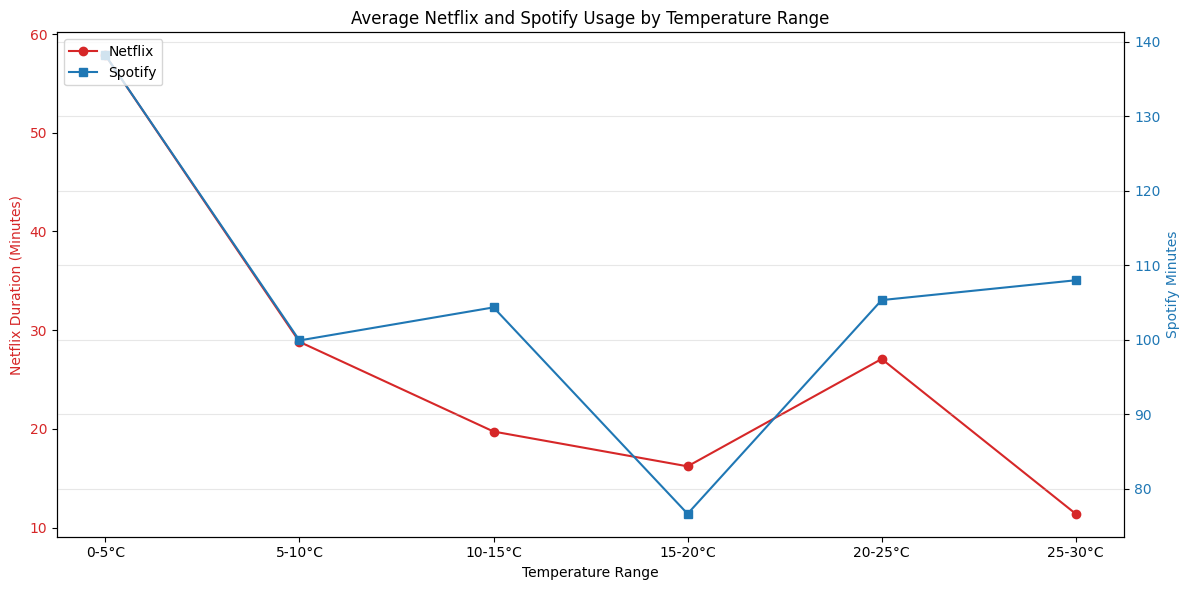


Data Coverage:
Days with Netflix data: 52
Days with Spotify data: 331
Total days in dataset: 368


In [44]:
# Correct column name for temperature
temperature_column = 'MeanTemperature'

# Create more appropriate temperature bins based on the actual distribution
merged_data['TemperatureRange'] = pd.cut(
    merged_data[temperature_column],
    bins=[0, 5, 10, 15, 20, 25, 30],  # Adjusted bins based on actual distribution
    labels=['0-5°C', '5-10°C', '10-15°C', '15-20°C', '20-25°C', '25-30°C']
)

# Add count of measurements to the aggregation
temp_usage_summary = merged_data.groupby('TemperatureRange').agg({
    'NetflixDuration': ['mean', 'count'],
    'SpotifyMinutes': ['mean', 'count']
}).reset_index()

# Flatten column names
temp_usage_summary.columns = ['TemperatureRange', 'NetflixMean', 'NetflixCount', 'SpotifyMean', 'SpotifyCount']

# Print the summary table with counts
print("\nAverage usage and number of observations by temperature range:")
print(temp_usage_summary)

# Visualization with dual y-axes for better scale comparison
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Netflix data
color1 = 'tab:red'
ax1.set_xlabel('Temperature Range')
ax1.set_ylabel('Netflix Duration (Minutes)', color=color1)
line1 = ax1.plot(temp_usage_summary['TemperatureRange'],
                 temp_usage_summary['NetflixMean'],
                 color=color1,
                 marker='o',
                 label='Netflix')
ax1.tick_params(axis='y', labelcolor=color1)

# Create second y-axis for Spotify
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Spotify Minutes', color=color2)
line2 = ax2.plot(temp_usage_summary['TemperatureRange'],
                 temp_usage_summary['SpotifyMean'],
                 color=color2,
                 marker='s',
                 label='Spotify')
ax2.tick_params(axis='y', labelcolor=color2)

# Add combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Average Netflix and Spotify Usage by Temperature Range')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print number of days with data for each service
print("\nData Coverage:")
print(f"Days with Netflix data: {(merged_data['NetflixDuration'] > 0).sum()}")
print(f"Days with Spotify data: {(merged_data['SpotifyMinutes'] > 0).sum()}")
print(f"Total days in dataset: {len(merged_data)}")


<ipython-input-45-1cdcfb375c3e>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_usage_summary = merged_data.groupby('TemperatureRange').agg({



Average usage of Netflix and Spotify by temperature range:
  TemperatureRange  NetflixDuration  SpotifyMinutes
0             <0°C              NaN             NaN
1           0-10°C        34.310811      107.130946
2          10-20°C        18.546584       95.033416
3          20-30°C        19.887218      106.524211
4            >30°C              NaN             NaN


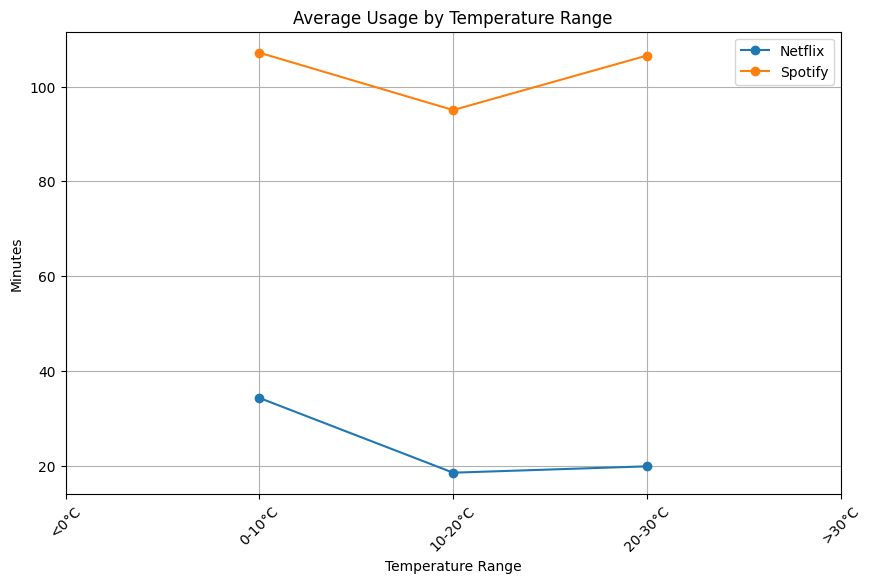

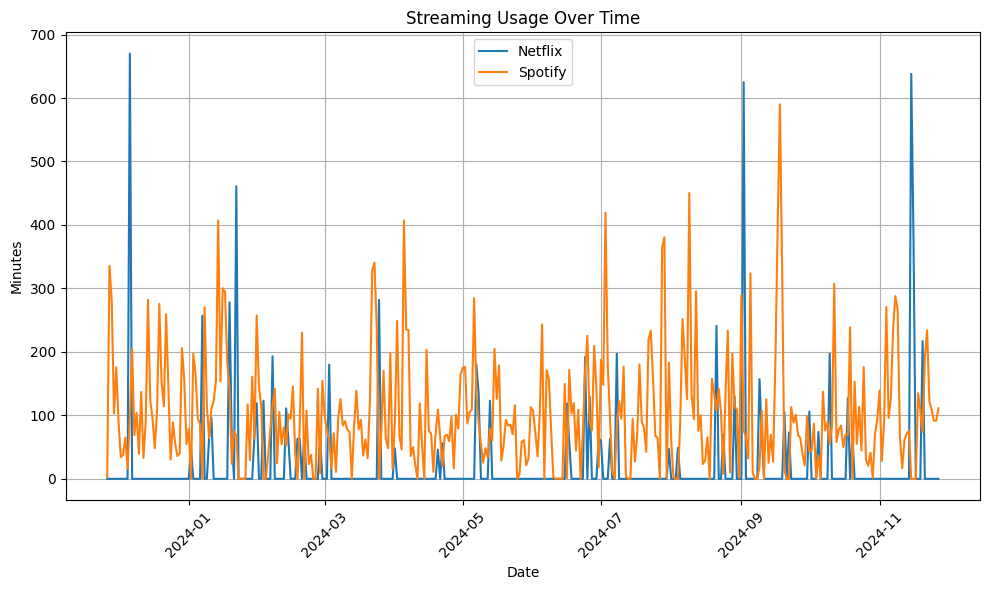

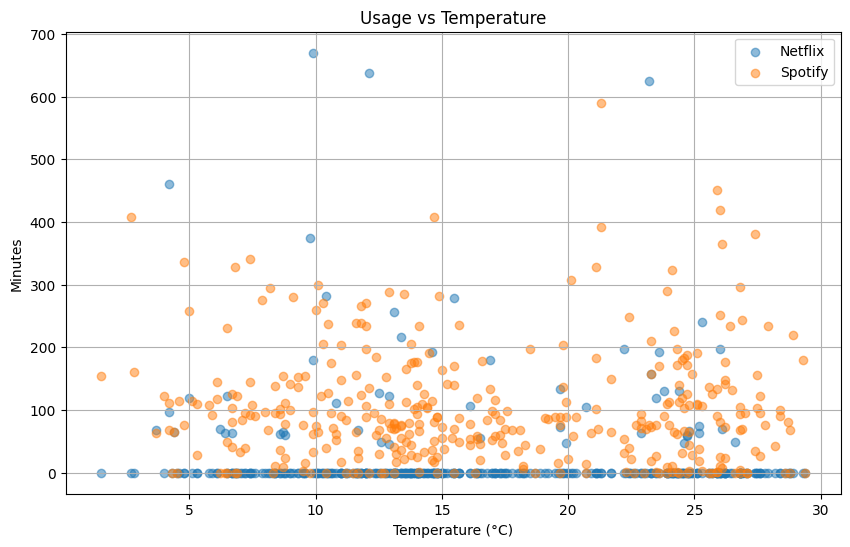


Correlation with temperature:
Netflix correlation: -0.06293847549557155
Spotify correlation: -0.0252976503091074


In [45]:

import matplotlib.pyplot as plt
import seaborn as sns

# Modified temperature range analysis
merged_data['TemperatureRange'] = pd.cut(
    merged_data['MeanTemperature'],
    bins=[-10, 0, 10, 20, 30, 40],
    labels=['<0°C', '0-10°C', '10-20°C', '20-30°C', '>30°C']
)

# Calculate average usage by temperature range
temp_usage_summary = merged_data.groupby('TemperatureRange').agg({
    'NetflixDuration': 'mean',
    'SpotifyMinutes': 'mean'
}).reset_index()

print("\nAverage usage of Netflix and Spotify by temperature range:")
print(temp_usage_summary)

# Create visualizations
plt.figure(figsize=(10, 6))
plt.plot(temp_usage_summary.index, temp_usage_summary['NetflixDuration'], marker='o', label='Netflix')
plt.plot(temp_usage_summary.index, temp_usage_summary['SpotifyMinutes'], marker='o', label='Spotify')
plt.title('Average Usage by Temperature Range')
plt.xlabel('Temperature Range')
plt.ylabel('Minutes')
plt.xticks(temp_usage_summary.index, temp_usage_summary['TemperatureRange'], rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Time series visualization
plt.figure(figsize=(10, 6))
plt.plot(merged_data['date'], merged_data['NetflixDuration'], label='Netflix')
plt.plot(merged_data['date'], merged_data['SpotifyMinutes'], label='Spotify')
plt.title('Streaming Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Minutes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Temperature correlation visualization
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['MeanTemperature'], merged_data['NetflixDuration'], alpha=0.5, label='Netflix')
plt.scatter(merged_data['MeanTemperature'], merged_data['SpotifyMinutes'], alpha=0.5, label='Spotify')
plt.title('Usage vs Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Minutes')
plt.legend()
plt.grid(True)
plt.show()

# Additional insights
print("\nCorrelation with temperature:")
print("Netflix correlation:", merged_data['NetflixDuration'].corr(merged_data['MeanTemperature']))
print("Spotify correlation:", merged_data['SpotifyMinutes'].corr(merged_data['MeanTemperature']))